<a href="https://colab.research.google.com/github/Madhuri-nallamothu/AUGMENTATION_GAN/blob/master/brain_tumor_object_detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Object Detection<br>
Implementing a brain tumor detection system using YOLOv8. Curate a diverse dataset, annotate images, and train models for accurate detection. Emphasizing ethical healthcare data usage, this project seeks robust precision and recall in identifying brain tumors through the YOLOv8 along with different sizes and optimizers.

## **Data Collection**

[Dataset](https://www.kaggle.com/datasets/ammarahmed310/labeled-mri-brain-tumor-dataset)<br>
A comprehensive dataset consisting of brain scans from multiple imaging modalities, including MRI, has been chosen for the training of the YOLOv7 model. The dataset has been carefully selected to provide exposure to a wide variety of clinical situations, including cases of pituitary, meningioma, glioma, and no tumor. The dataset was obtained from Kagle and Hayatabad Medical Complex Peshawar. The specifications of the dataset, consisting of 1594 healthy brain samples, 1321 glioma, 1339 meningioma, and 1457 pituitary brain tumor samples.

## Importing Libraries

In [ ]:
# Set the system locale to UTF-8
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8
!export LANGUAGE=C.UTF-8


In [ ]:
!pip install Augmentor
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

In [ ]:
#zip_path = '/content/drive/MyDrive/brain_tumor_object_detection-1/data/data.zip'
extract_path = '/content/drive/MyDrive/Brain Tumor labeled dataset-1'

In [ ]:
!ls "/content/drive/MyDrive/Brain Tumor labeled dataset-1/meningioma/"

 classes.txt  'gg (9).txt'


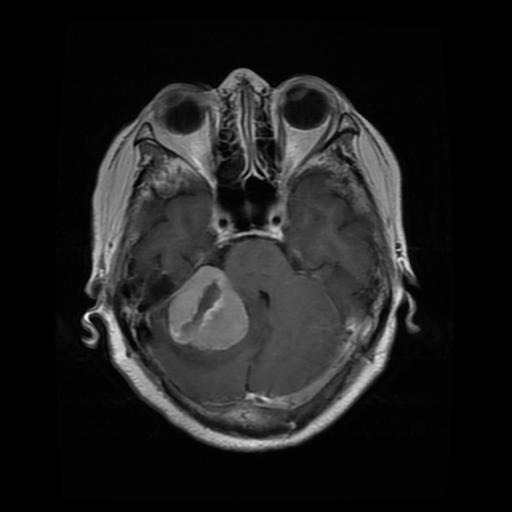

In [ ]:
sample_image = Image.open('/content/drive/MyDrive/Brain Tumor labeled dataset-1/train/meningioma/Tr-me_0022.jpg')
sample_image


In [ ]:
width, height = sample_image.size
print(f"Width: {width} pixels")
print(f"Height: {height} pixels")


Width: 512 pixels
Height: 512 pixels


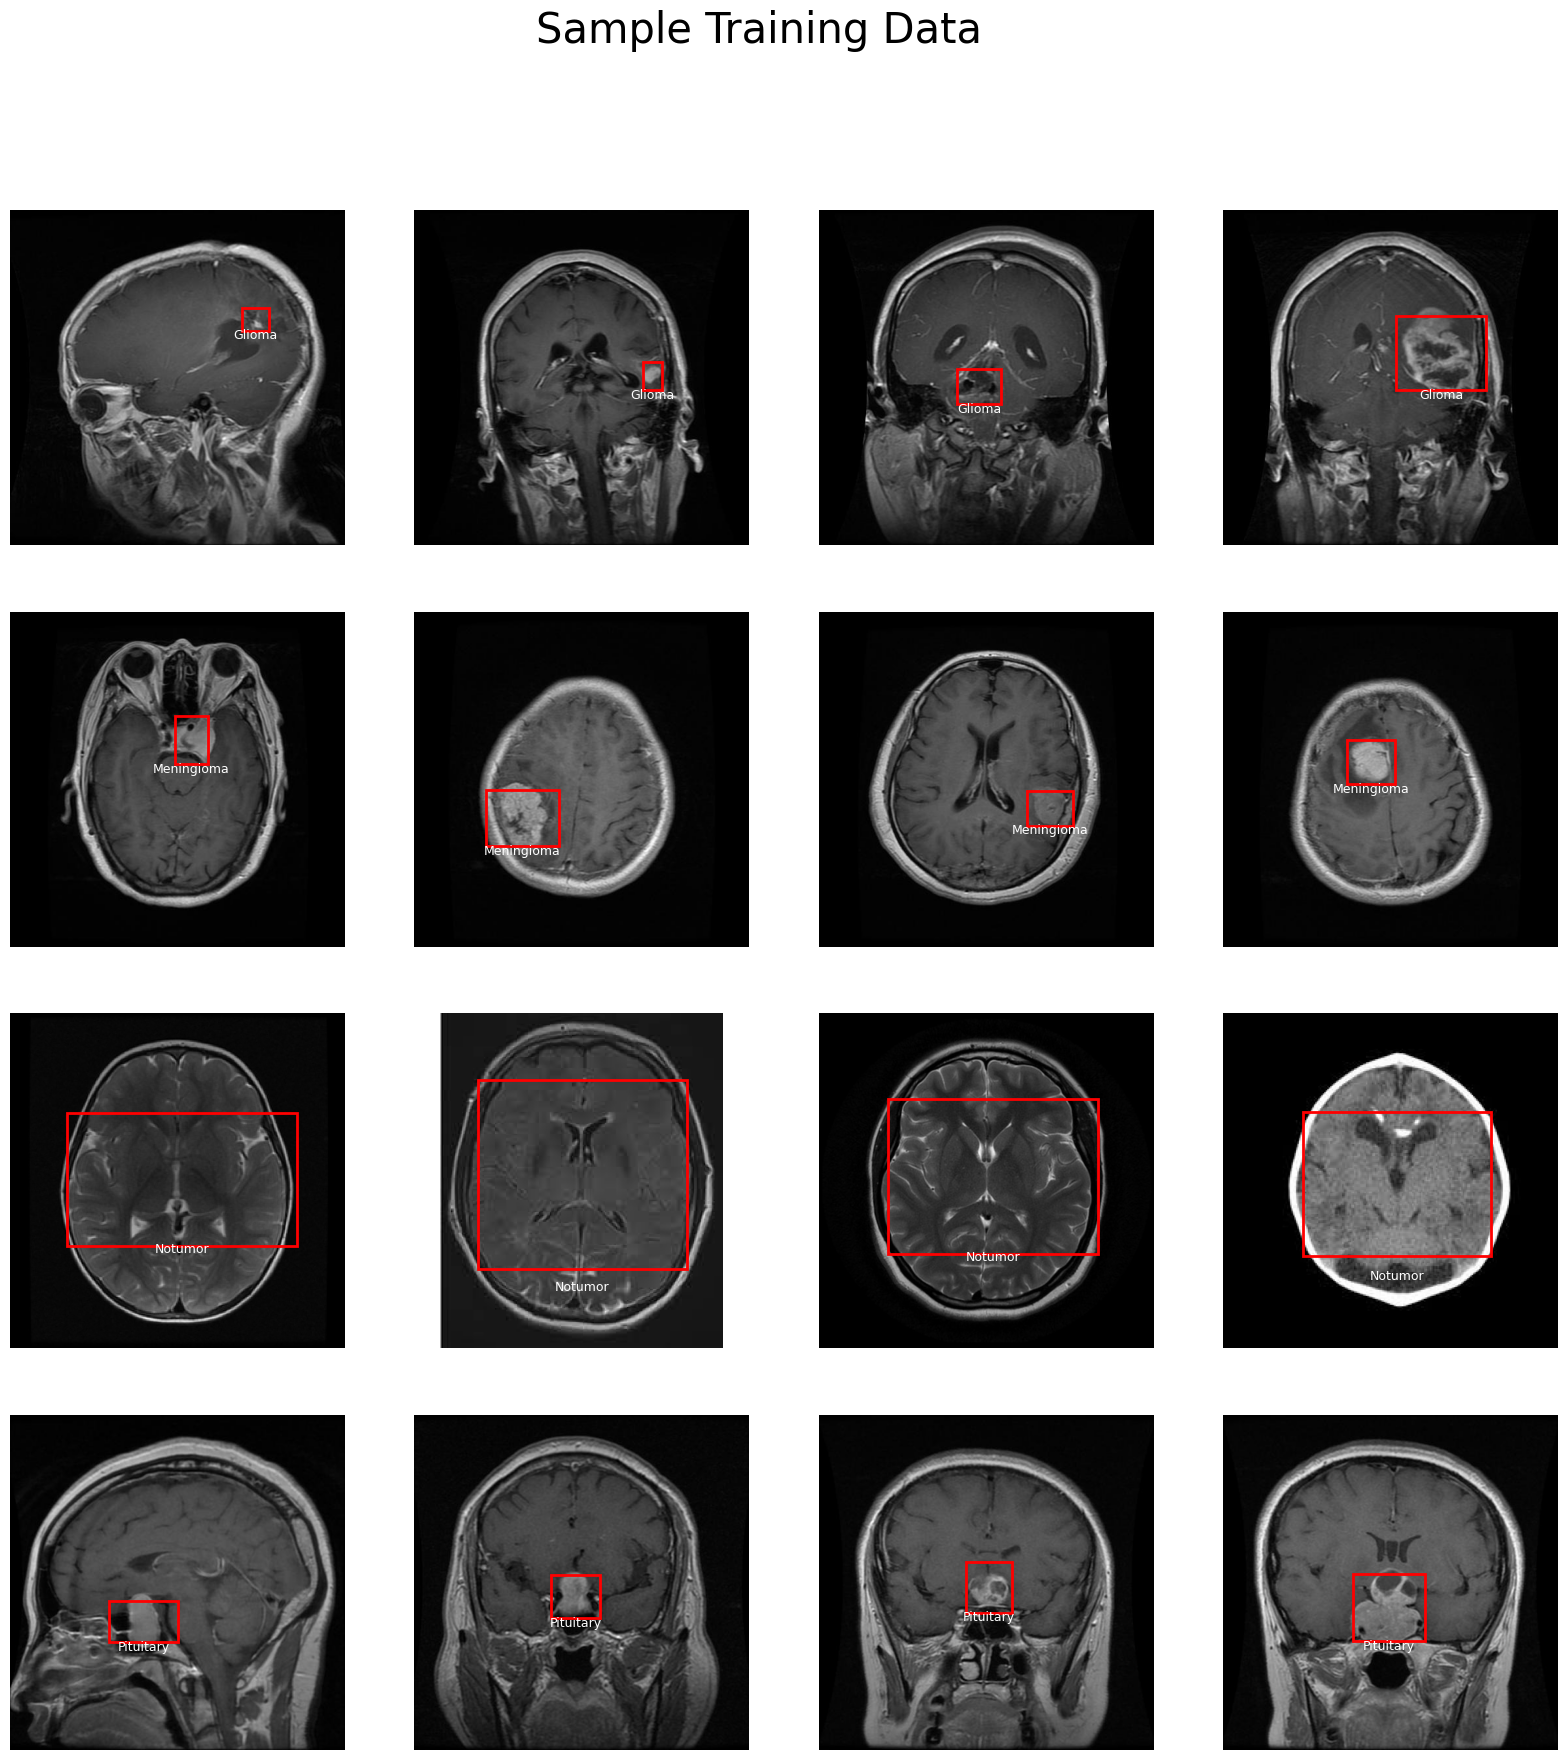

In [ ]:
# Plotting the training data with bounding boxes
dataset_directory = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/train'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

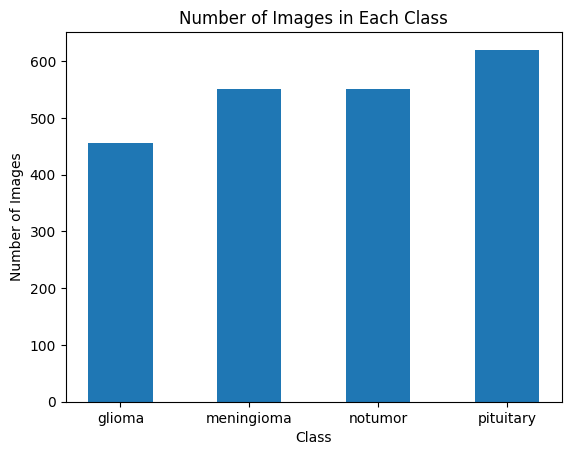

In [ ]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

## Train-Test Split

In [ ]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)




In [ ]:
dataset_directory = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [ ]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [ ]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

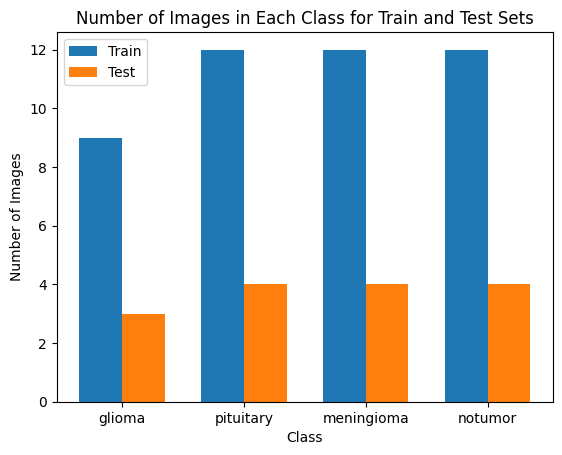

In [ ]:
dataset_directory = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/'
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

## YOLOv8n

### Modelling

In [ ]:
!ls "/content/drive/MyDrive/Brain Tumor labeled dataset-1/train"

glioma	glioma.cache  meningioma  notumor  pituitary


In [ ]:
!cat "/content/drive/MyDrive/Brain Tumor labeled dataset-1/brain_tumor_dataset.yaml"


path: /content/drive/MyDrive/Brain Tumor labeled dataset-1
train: /content/drive/MyDrive/Brain Tumor labeled dataset-1/train
val: /content/drive/MyDrive/Brain Tumor labeled dataset-1/test

names:
    0: glioma
    1: meningioma
    2: notumor
    3: pituitary


In [ ]:
with open('/content/drive/MyDrive/Brain Tumor labeled dataset-1/brain_tumor_dataset.yaml', 'r') as file:
    content = file.read()
print(content)



path: /content/drive/MyDrive/Brain Tumor labeled dataset-1
train: /content/drive/MyDrive/Brain Tumor labeled dataset-1/train
val: /content/drive/MyDrive/Brain Tumor labeled dataset-1/test

names:
    0: glioma
    1: meningioma
    2: notumor
    3: pituitary



In [ ]:
yaml_content = """
path: /content/drive/MyDrive/Brain Tumor labeled dataset-1
train: /content/drive/MyDrive/Brain Tumor labeled dataset-1/train
val: /content/drive/MyDrive/Brain Tumor labeled dataset-1/test

names:
    0: glioma
    1: meningioma
    2: notumor
    3: pituitary
"""

with open('/content/drive/MyDrive/Brain Tumor labeled dataset-1/brain_tumor_dataset.yaml', 'w') as file:
    file.write(yaml_content)


In [ ]:

!pip show ultralytics
from ultralytics import YOLO

# Load pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

# Train the model with your custom dataset
model.train(
    data='/content/drive/MyDrive/Brain Tumor labeled dataset-1/brain_tumor_dataset.yaml',
    epochs=10,
    imgsz=640,
    batch=16,  # You can adjust this based on available GPU memory
    workers=8,  # Number of workers for data loading
    project='runs/detect',  # Directory to save results
    name='train_brain_tumor'  # Name of the training run
)


Name: ultralytics
Version: 8.3.99
Summary: Ultralytics YOLO 🚀 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://ultralytics.com
Author: 
Author-email: Glenn Jocher <glenn.jocher@ultralytics.com>, Jing Qiu <jing.qiu@ultralytics.com>
License: AGPL-3.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, torch, torchvision, tqdm, ultralytics-thop
Required-by: 


100%|██████████| 6.25M/6.25M [00:00<00:00, 17.2MB/s]


Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Brain Tumor labeled dataset-1/brain_tumor_dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/detect, name=train_brain_tumor, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

100%|██████████| 755k/755k [00:00<00:00, 3.23MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Brain Tumor labeled dataset-1/train/glioma.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/glioma.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs/detect/train_brain_tumor/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train_brain_tumor
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.832      5.158       1.97         13        640: 100%|██████████| 3/3 [01:06<00:00, 22.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.72s/it]

                   all         15         15   0.000929       0.25     0.0548     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G        1.8      5.061      1.959         13        640: 100%|██████████| 3/3 [00:36<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

                   all         15         15    0.00106       0.25     0.0588     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.672      4.781      1.887         13        640: 100%|██████████| 3/3 [00:35<00:00, 11.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]

                   all         15         15    0.00141       0.25      0.072     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.589      4.694       1.78         13        640: 100%|██████████| 3/3 [00:35<00:00, 11.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

                   all         15         15    0.00212      0.312      0.115     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.399      4.407      1.582         13        640: 100%|██████████| 3/3 [00:35<00:00, 11.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]

                   all         15         15    0.00269      0.375      0.152     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.298      4.086      1.471         13        640: 100%|██████████| 3/3 [00:33<00:00, 11.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

                   all         15         15    0.00285      0.375      0.175     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.285      4.005      1.431         13        640: 100%|██████████| 3/3 [00:34<00:00, 11.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]

                   all         15         15    0.00324      0.438      0.199     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G       1.24      3.794      1.437         13        640: 100%|██████████| 3/3 [00:37<00:00, 12.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]

                   all         15         15     0.0034      0.438      0.198      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G       1.21      3.656      1.345         13        640: 100%|██████████| 3/3 [00:37<00:00, 12.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

                   all         15         15    0.00375      0.521      0.274      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.167      3.598      1.304         13        640: 100%|██████████| 3/3 [00:34<00:00, 11.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]

                   all         15         15    0.00388      0.521      0.285      0.204



10 epochs completed in 0.125 hours.
Optimizer stripped from runs/detect/train_brain_tumor/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train_brain_tumor/weights/best.pt, 6.2MB

Validating runs/detect/train_brain_tumor/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


                   all         15         15    0.00385      0.521      0.285      0.203
                glioma          4          4    0.00173       0.25      0.246      0.172
            meningioma          4          4    0.00105        0.5      0.123     0.0983
               notumor          3          3   0.000597      0.333     0.0281     0.0225
             pituitary          4          4      0.012          1      0.745      0.519
Speed: 2.3ms preprocess, 245.8ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/train_brain_tumor


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x791f54aad3d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

### Performance Metrics

In [ ]:
def plot_images(image_paths):
    fig, axes = plt.subplots(len(image_paths), 1, figsize=(80, 80))

    for i, ax in enumerate(axes):
        image_path = image_paths[i]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(image_path))

    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Verify if the target directory exists
directory_path = '/content/runs/detect/train_brain_tumor/weights'

if os.path.exists(directory_path):
    print(f"Directory exists: {directory_path}")
    print("Files in the directory:", os.listdir(directory_path))
else:
    print(f"Directory not found: {directory_path}")


Directory exists: /content/runs/detect/train_brain_tumor/weights
Files in the directory: ['best.pt', 'last.pt']


In [ ]:
import os

# Check if the file exists
file_path = '/content/runs/detect/train_brain_tumor/F1_curve.png'
if os.path.exists(file_path):
    print(f"File {file_path} exists.")
else:
    print(f"File {file_path} does not exist.")


File /content/runs/detect/train_brain_tumor/F1_curve.png exists.


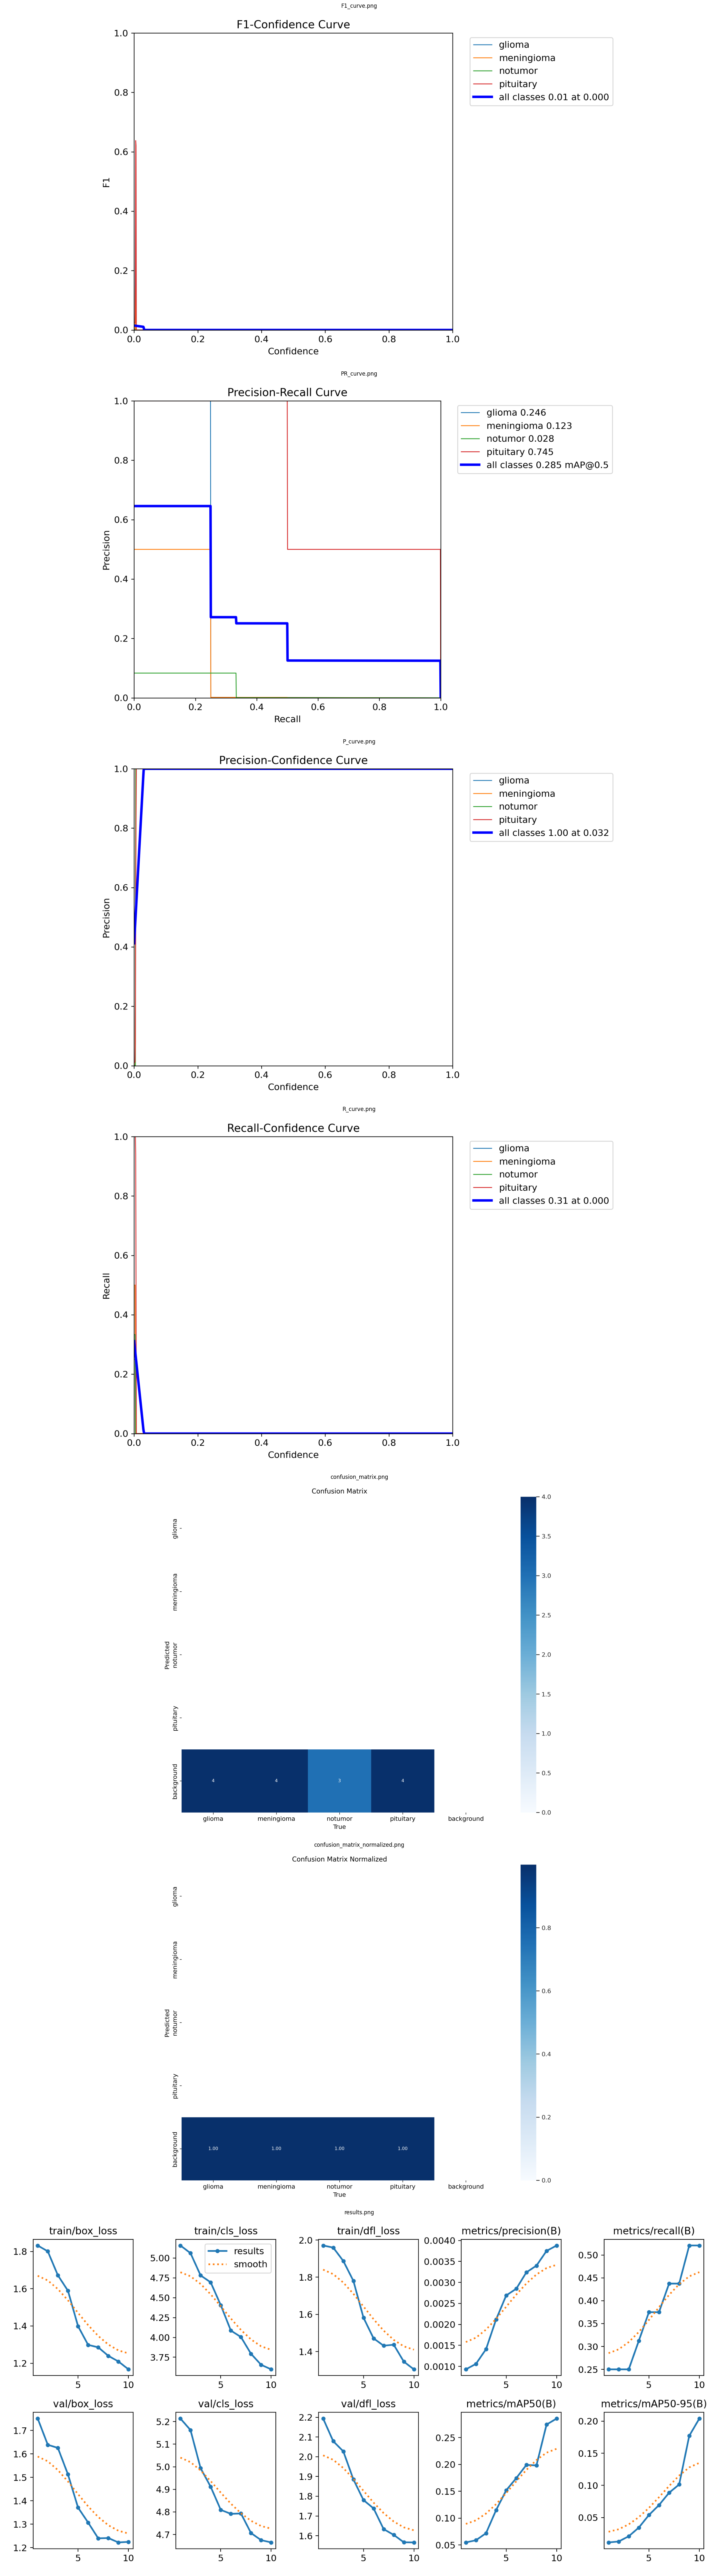

In [ ]:
image_paths = [
    '/content/runs/detect/train_brain_tumor/F1_curve.png',
    '/content/runs/detect/train_brain_tumor/PR_curve.png',
    '/content/runs/detect/train_brain_tumor/P_curve.png',
    '/content/runs/detect/train_brain_tumor/R_curve.png',
    '/content/runs/detect/train_brain_tumor/confusion_matrix.png',
    '/content/runs/detect/train_brain_tumor/confusion_matrix_normalized.png',
    '/content/runs/detect/train_brain_tumor/results.png',
]
plot_images(image_paths)

### Testing

In [ ]:
def predict_results(test_images_dir):
    model = YOLO('/content/runs/detect/train_brain_tumor/weights/best.pt')
    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=320, conf=0.3)

In [ ]:
# List the files in the 'test' directory
test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test'
print(os.listdir(test_dir))


['glioma', 'pituitary', 'meningioma', 'notumor', 'glioma.cache']


In [ ]:
glioma_test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test/glioma'
print(os.listdir(glioma_test_dir))


['Tr-gl_0011.jpg', 'Tr-gl_0011.txt', 'Tr-gl_0021.txt', 'Tr-gl_0024.jpg', 'Tr-gl_0024.txt', 'Tr-gl_0021.jpg']



image 1/1 /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/glioma/Tr-gl_0011.jpg: 640x640 (no detections), 194.0ms
Speed: 5.5ms preprocess, 194.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


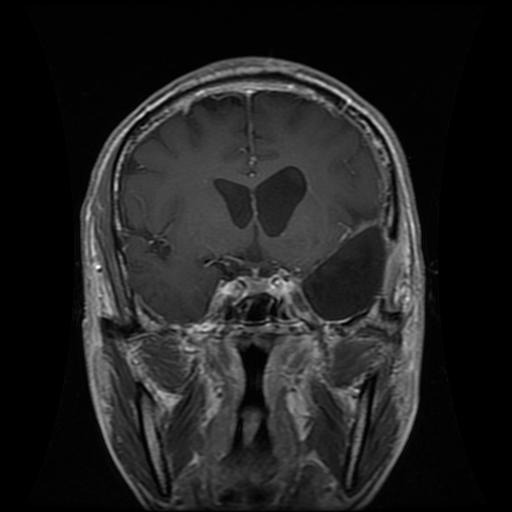


image 1/1 /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/glioma/Tr-gl_0024.jpg: 640x640 (no detections), 233.1ms
Speed: 9.1ms preprocess, 233.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


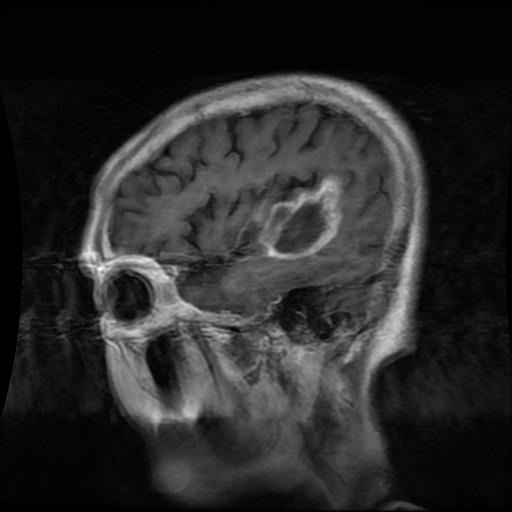


image 1/1 /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/glioma/Tr-gl_0021.jpg: 640x640 (no detections), 218.6ms
Speed: 8.1ms preprocess, 218.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


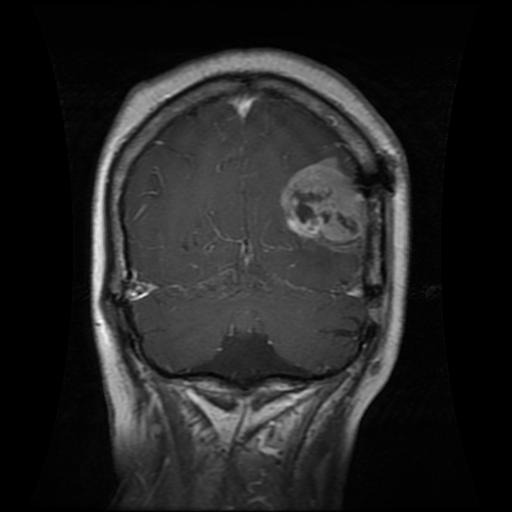

In [ ]:
!pip install ultralytics

import os
from ultralytics import YOLO

# Define the directory containing the test images
glioma_test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test/glioma'

# Load the YOLOv8 model
model_path = '/content/runs/detect/train_brain_tumor/weights/best.pt'  # Adjust the model path if necessary
model = YOLO(model_path)

# List all the images in the 'glioma' folder
image_paths = [os.path.join(glioma_test_dir, f) for f in os.listdir(glioma_test_dir) if f.endswith(('.jpg', '.png'))]

# Loop through each image, make predictions, and show results
for image_path in image_paths:
    results = model(image_path)  # Predict on the image
    result = results[0]  # Get the first result (there should only be one result per image)
    result.show()  # Display the predictions on the image



In [ ]:
!pip install ultralytics

import os
from ultralytics import YOLO

# Define the directory containing the test images
glioma_test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test/meningioma'

# Load the YOLOv8 model
model_path = '/content/runs/detect/train_brain_tumor/weights/best.pt'  # Adjust the model path if necessary
model = YOLO(model_path)

# List all the images in the 'glioma' folder
image_paths = [os.path.join(glioma_test_dir, f) for f in os.listdir(glioma_test_dir) if f.endswith(('.jpg', '.png'))]

# Loop through each image, make predictions, and show results
for image_path in image_paths:
    results = model(image_path)  # Predict on the image
    result = results[0]  # Get the first result (there should only be one result per image)
    result.show()  # Display the predictions on the image



image 1/1 /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/notumor/Tr-no_0022.jpg: 640x640 (no detections), 206.5ms
Speed: 4.0ms preprocess, 206.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


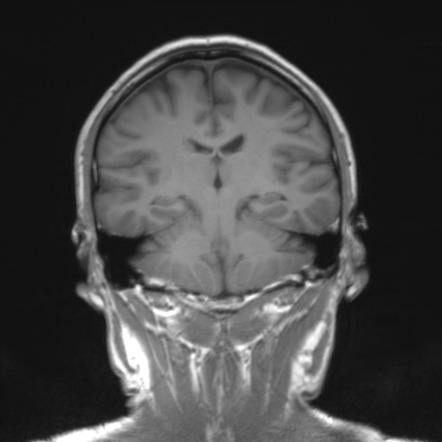


image 1/1 /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/notumor/Tr-no_0017.jpg: 640x640 (no detections), 221.1ms
Speed: 8.2ms preprocess, 221.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


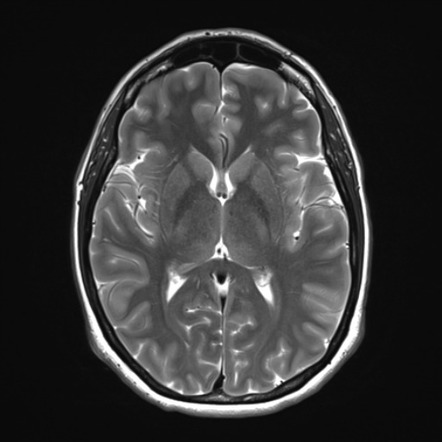


image 1/1 /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/notumor/Tr-no_0019.jpg: 640x640 (no detections), 226.6ms
Speed: 6.5ms preprocess, 226.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


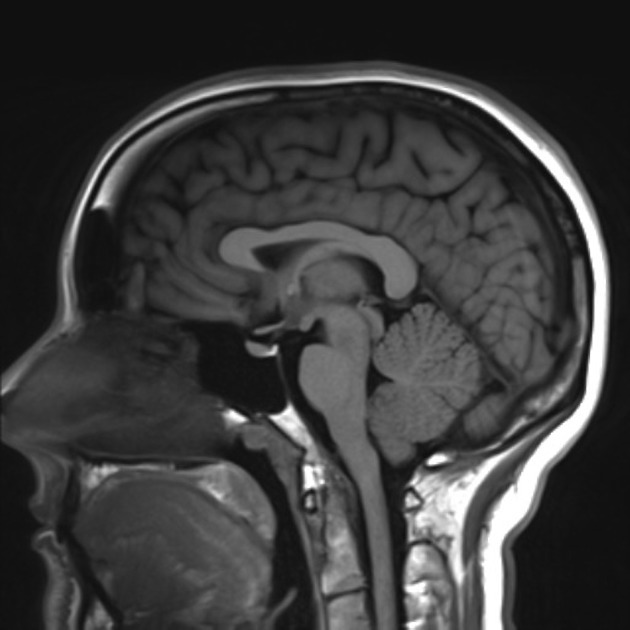


image 1/1 /content/drive/MyDrive/Brain Tumor labeled dataset-1/test/notumor/Tr-no_0016.jpg: 640x640 (no detections), 228.9ms
Speed: 6.0ms preprocess, 228.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


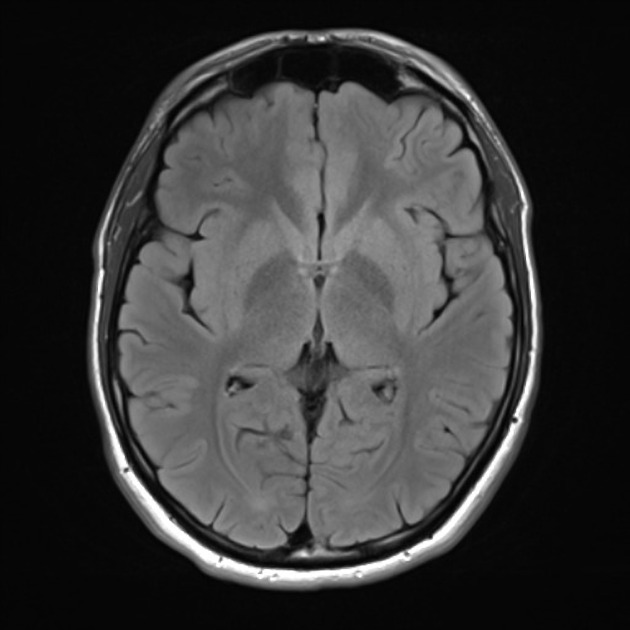

In [ ]:
!pip install ultralytics

import os
from ultralytics import YOLO

# Define the directory containing the test images
glioma_test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test/notumor'

# Load the YOLOv8 model
model_path = '/content/runs/detect/train_brain_tumor/weights/best.pt'  # Adjust the model path if necessary
model = YOLO(model_path)

# List all the images in the 'glioma' folder
image_paths = [os.path.join(glioma_test_dir, f) for f in os.listdir(glioma_test_dir) if f.endswith(('.jpg', '.png'))]

# Loop through each image, make predictions, and show results
for image_path in image_paths:
    results = model(image_path)  # Predict on the image
    result = results[0]  # Get the first result (there should only be one result per image)
    result.show()  # Display the predictions on the image

In [ ]:
!pip install ultralytics

import os
from ultralytics import YOLO

# Define the directory containing the test images
glioma_test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test/pituitary'

# Load the YOLOv8 model
model_path = '/content/runs/detect/train_brain_tumor/weights/best.pt'  # Adjust the model path if necessary
model = YOLO(model_path)

# List all the images in the 'glioma' folder
image_paths = [os.path.join(glioma_test_dir, f) for f in os.listdir(glioma_test_dir) if f.endswith(('.jpg', '.png'))]

# Loop through each image, make predictions, and show results
for image_path in image_paths:
    results = model(image_path)  # Predict on the image
    result = results[0]  # Get the first result (there should only be one result per image)
    result.show()  # Display the predictions on the image

In [ ]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

In [ ]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [ ]:
'''dirs = ['/content/drive/MyDrive/brain_tumor_object_detection/inference_results/test_results_on_all_images/glioma/detect/predict',
        '/content/drive/MyDrive/brain_tumor_object_detection/inference_results/test_results_on_all_images/meningioma/detect/predict',
        '/content/drive/MyDrive/brain_tumor_object_detection/inference_results/test_results_on_all_images/notumor/detect/predict',
        '/content/drive/MyDrive/brain_tumor_object_detection/inference_results/test_results_on_all_images/pituitary/detect/predict']

all_images = []
for directory in dirs:
    random_images = get_random_images_from_dir(directory, num_images=5)
    all_images.extend(random_images)

display_images(all_images)

## YOLOv8n Adamax

### Modelling

In [ ]:
yolov8n_btd_model_adamax = YOLO('yolov8n.yaml')
yolov8n_btd_model_adamax_results = yolov8n_btd_model_adamax.train(data = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/brain_tumor_dataset.yaml',
                                                    epochs = 30,
                                                    batch = 32,
                                                    name = 'YOLOv8n_Adamax',
                                                    optimizer = 'Adamax',
                                                    lr0 = 0.001,
                                                    lrf = 0.001,
                                                    momentum = 0.85,
                                                    dropout = 0.5
                                                    )

### Performance Metrics

In [ ]:
image_paths = [
    '/content/runs/detect/YOLOv8n_Adamax3/F1_curve.png',
    '/content/runs/detect/YOLOv8n_Adamax3/PR_curve.png',
    '/content/runs/detect/YOLOv8n_Adamax3/P_curve.png',
    '/content/runs/detect/YOLOv8n_Adamax3/R_curve.png',
    '/content/runs/detect/YOLOv8n_Adamax3/confusion_matrix.png',
    '/content/runs/detect/YOLOv8n_Adamax3/confusion_matrix_normalized.png',
    '/content/runs/detect/YOLOv8n_Adamax3/results.png',
]
plot_images(image_paths)

### Testing

In [ ]:
def predict_results_on_YOLOv8n_Adamax(test_images_dir):
    model = YOLO('/content/runs/detect/YOLOv8n_Adamax3/weights/best.pt')

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=512, conf=0.3)

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8m model trained with Adam/Adamax/RMSProp
model_path = '/content/runs/detect/train_brain_tumor/weights'  # Update path if necessary
model = YOLO(model_path)

# Define prediction function
def predict_results(test_dir):
    import os
    image_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    for image_file in image_files:
        image_path = os.path.join(test_dir, image_file)
        results = model(image_path)
        for result in results:
            result.show()

# Correct path to the test directory
test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test'

# Run predictions
predict_results(test_dir)


In [ ]:
from ultralytics import YOLO
import os

# Load the YOLOv8m model
model_path = '/content/runs/detect/train_brain_tumor/weights/best.pt'  # Update path if needed
model = YOLO(model_path)

# Define the correct prediction function
def predict_results(test_dir):
    # List all image files in the test directory
    image_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Perform prediction on each image
    for image_file in image_files:
        image_path = os.path.join(test_dir, image_file)

        # Run inference
        results = model(image_path)

        # Loop through the results and show predictions
        for result in results:
            result.show()

# Run predictions on the test directory
test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test'
predict_results(test_dir)  # Call the correct function


In [ ]:
'''test_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test'
predict_results_on_YOLOv8m_Adam(test_dir)

In [ ]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [ ]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

In [ ]:
import os

image_dir = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/test'
print(os.listdir(image_dir))  # Check if the directory exists and contains images


In [ ]:
def get_random_images_from_dir(image_dir, num_images):
    import random
    import os
    from PIL import Image

    # List all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Check if there are enough images
    if len(image_files) == 0:
        print(f"No images found in {image_dir}")
        return []

    # Get random images
    num_images = min(num_images, len(image_files))
    random_files = random.sample(image_files, num_images)

    # Load the images
    images = [Image.open(os.path.join(image_dir, f)) for f in random_files]
    return images


In [ ]:
random_images = get_random_images_from_dir('/content/drive/MyDrive/Brain Tumor labeled dataset-1/test/glioma', 20)

if len(random_images) == 0:
    print("No images to display. Check the directory path or image files.")
else:
    display_images(random_images)


In [ ]:
import matplotlib.pyplot as plt

def display_images(images):
    num_images = len(images)

    if num_images == 0:
        print("No images to display.")
        return

    # Calculate grid size
    num_cols = 5
    num_rows = (num_images // num_cols) + (1 if num_images % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
random_images = get_random_images_from_dir('/content/drive/MyDrive/Brain Tumor labeled dataset-1/test', 10)
display_images(random_images)

## YOLOv8m RMSProp

### Modelling

In [ ]:
from ultralytics import YOLO

# Check if YOLO is imported correctly
print(YOLO)


In [ ]:
yolov8m_btd_model = YOLO('yolov8m.yaml')
yolov8m_btd_model_results = yolov8m_btd_model.train(data = '/content/drive/MyDrive/Brain Tumor labeled dataset-1/brain_tumor_dataset.yaml',
                                                    epochs = 10,
                                                    batch = 32,
                                                    name = 'YOLOv8m',
                                                    optimizer = 'RMSProp',
                                                    lr0 = 0.001,
                                                    lrf = 0.001,
                                                    momentum = 0.90,
                                                    dropout = 0.2
                                                    )

### Performance Metrics

In [ ]:
image_paths = [
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m2/detect/YOLOv8m5/F1_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m/detect/YOLOv8m5/PR_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m/detect/YOLOv8m5/P_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m/detect/YOLOv8m5/R_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m/detect/YOLOv8m5/confusion_matrix.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m/detect/YOLOv8m5/confusion_matrix_normalized.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m/detect/YOLOv8m5/results.png',
]
plot_images(image_paths)

### Testing

In [ ]:
def predict_results_on_YOLOv8m(test_images_dir):
    model = YOLO('/content/drive/MyDrive/brain_tumor_object_detection/yolov8m/detect/YOLOv8m5/weights/best.pt')
    # os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=512, conf=0.3)

In [ ]:
predict_results_on_YOLOv8m('/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images')

In [ ]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

In [ ]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [ ]:
random_images = get_random_images_from_dir('/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_test_reults/detect/predict', 20)
display_images(random_images)

## YOLOv8m Adam

### Modelling

In [ ]:
yolov8m_btd_model_optimized = YOLO('yolov8m.yaml')
yolov8m_btd_model_optimized_results = yolov8m_btd_model_optimized.train(data = '/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml',
                                                    epochs = 30,
                                                    batch = 32,
                                                    name = 'YOLOv8m',
                                                    optimizer = 'Adam',
                                                    lr0 = 0.001,
                                                    lrf = 0.001,
                                                    momentum = 0.90,
                                                    dropout = 0.3
                                                    )

In [ ]:
test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images'
predict_results_on_YOLOv8m(test_dir)

### Performance Metrics

In [ ]:
image_paths = [
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/F1_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/PR_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/P_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/R_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/confusion_matrix.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/confusion_matrix_normalized.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/results.png',
]
plot_images(image_paths)

### Testing

In [ ]:
def predict_results_on_YOLOv8m_Adam(test_images_dir):
    model = YOLO('/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adam/detect/YOLOv8m/weights/best.pt')
    # os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=512, conf=0.3)

In [ ]:
test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images'
predict_results_on_YOLOv8m_Adam(test_dir)

In [ ]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [ ]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

In [ ]:
random_images = get_random_images_from_dir('/content/drive/MyDrive/brain_tumor_object_detection/YOLOv8_Adam_test_reults/detect/predict2', 20)
display_images(random_images)

## YOLOv8m Adamax

### Modelling

In [ ]:
yolov8m_btd_model_adamax = YOLO('yolov8m.yaml')
yolov8m_btd_model_adamax_results = yolov8m_btd_model_adamax.train(data = '/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml',
                                                    epochs = 30,
                                                    batch = 32,
                                                    name = 'YOLOv8m_Adamax',
                                                    optimizer = 'Adamax',
                                                    lr0 = 0.001,
                                                    lrf = 0.001,
                                                    momentum = 0.89,
                                                    dropout = 0.4
                                                    )

### Performance Metrics

In [ ]:
image_paths = [
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/F1_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/PR_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/P_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/R_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/confusion_matrix.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/confusion_matrix_normalized.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/results.png',
]
plot_images(image_paths)

### Testing

In [ ]:
def predict_results_on_YOLOv8m_Adam(test_images_dir):
    model = YOLO('/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax/detect/YOLOv8m_Adamax/weights/best.pt')

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=512, conf=0.3)

In [ ]:
test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images'
predict_results_on_YOLOv8m_Adam(test_dir)

In [ ]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [ ]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

In [ ]:
random_images = get_random_images_from_dir('/content/drive/MyDrive/brain_tumor_object_detection/yolov8m_Adamax_test_results/detect/predict', 20)
display_images(random_images)